# VALIDATIONS

In [1]:

# LIBRARIES
import yfinance as yf
from pypfopt import risk_models
from pypfopt import expected_returns
from pypfopt.hierarchical_portfolio import HRPOpt
from pypfopt.efficient_frontier import EfficientFrontier
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from datetime import datetime
from scipy.optimize import minimize
from scipy.spatial.distance import squareform
from scipy.cluster.hierarchy import linkage, dendrogram, leaves_list

In [2]:
tickers = ["ABBV", "MET", "OXY", "PERI"]
start_date = "2020-01-02"
end_date = "2024-01-23"

data = yf.download(tickers, start=start_date, end=end_date)['Adj Close']

mu = expected_returns.mean_historical_return(data)
S = risk_models.sample_cov(data)
bounds = [(0.10, 1.0) for _ in range(len(tickers))]

[*********************100%***********************]  4 of 4 completed


## 1-. MIN VARIANCE

In [ ]:
try:
    ef = EfficientFrontier(mu, S, weight_bounds=bounds)
    weights = ef.min_volatility()
    cleaned_weights = ef.clean_weights()

    print(cleaned_weights)
    ef.portfolio_performance(verbose=True)

except OptimizationError as e:
    print("Could not find an optimization solution with the given constraints:", e)

## 2-. MAX SHARPE RATIO

In [ ]:
try:
    ef = EfficientFrontier(mu, S, weight_bounds=bounds)
    weights = ef.max_sharpe()
    cleaned_weights = ef.clean_weights()

    print(cleaned_weights)
    ef.portfolio_performance(verbose=True)

except OptimizationError as e:
    print("Could not find an optimization solution with the given constraints:", e)

## 3-. OMEGA

[*********************100%***********************]  5 of 5 completed

Optimal Portfolio Weights for Omega QAA using SLSQP optimization:
ABBV    0.1
MET     0.1
OXY     0.1
PERI    0.7
Name: Optimal Weights, dtype: float64

---

Portfolio Return: 0.18%
Benchmark Return (SPY): 0.06%
Risk-Free Rate Return: 0.01%

---

Portfolio Volatility: 3.12%
Benchmark Volatility (SPY): 1.43%
Risk-Free Rate Volatility: 0.00%

---



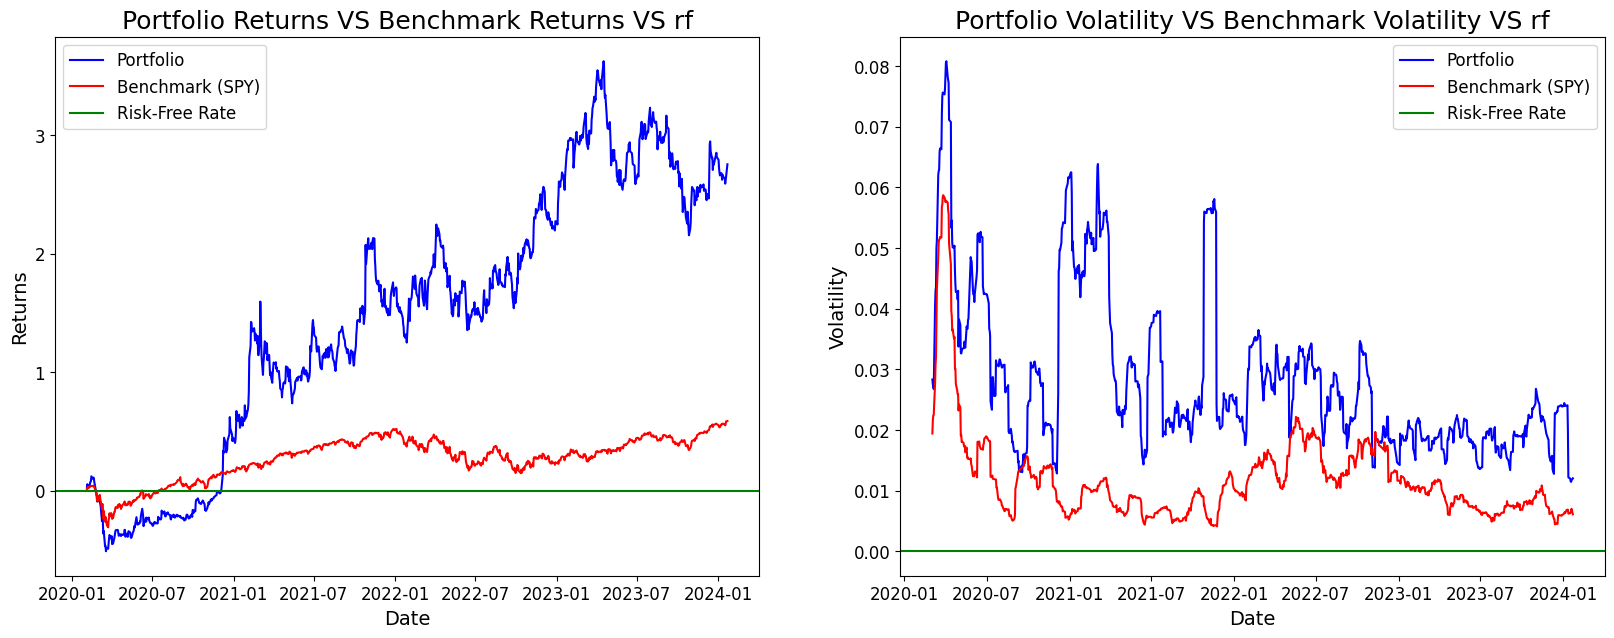

In [3]:
from functions import QAA

# EXAMPLE
qaa_instance = QAA(
    tickers=["ABBV", "MET", "OXY", "PERI"],
    benchmark="SPY",
    rf=0.02,
    lower_bound=0.1,
    higher_bound=0.90,
    start_date="2020-02-01",
    end_date="2024-01-23",
    expected_returns=np.array([.15, .1, .1, .1]),
    opinions=np.array([[1, 0, 0, 0], [0, 1, -3, 0], [0, 0, 1, -1], [0, 0, 0, 0]]),
    MAR=0.2,
    optimization_model="SLSQP", # SI DAN LOS PESOS CORRECTOS
    #optimization_model="MONTECARLO", # SI DAN LOS PESOS CORRECTOS
    #optimization_model="GRADIENT DESCENT", # NO DAN LOS PESOS CORRECTOS
    #optimization_model="COBYLA" AJUSTAR LA FUNCION Y HACER QUE FUNCIONE
    QAA_strategy="OMEGA",
)

try:
    data, returns, std, var, cov, corr = qaa_instance.assets_metrics()

    optimal_weights = qaa_instance.QAA_strategy_selection(returns=returns)

    qaa_instance.portfolio_metrics(returns)

except ValueError as ve:
    print(f"Error: {str(ve)}")

In [ ]:
import yfinance as yf
import numpy as np
import pandas as pd
from scipy.optimize import minimize



# 1. Obtener datos históricos de precios
tickers = ['ABBV', 'MET', 'OXY', 'PERI', 'SPY']
data = yf.download(tickers, start="2020-02-01", end="2024-01-23")['Adj Close']

# 2. Calcular los rendimientos diarios
rendimientos = data.pct_change().dropna()

# Funciones para calcular Downside Risk y Upside Risk
def downside_risk(diferencias):
    negative_differences = diferencias[diferencias < 0]
    return negative_differences.std() * np.sqrt(252)  # Anualizado

def upside_risk(diferencias):
    positive_differences = diferencias[diferencias > 0]
    return positive_differences.std() * np.sqrt(252)  # Anualizado

# 3. y 4. Calcular Downside Risk y Upside Risk para cada activo
omegas = {}
for ticker in tickers[:-1]:  # Excluir SPY, el benchmark
    diferencias = rendimientos[ticker] - rendimientos['SPY']
    omegas[ticker] = upside_risk(diferencias) / downside_risk(diferencias)

# 5. Omega ya calculado en el paso anterior, procedemos a la optimización
# Función objetivo: Minimizar la inversa del Omega del portafolio
def objective(weights):
    omega_portfolio = sum([omegas[ticker] * weight for ticker, weight in zip(tickers[:-1], weights)])
    return -omega_portfolio  # Negativo porque queremos maximizar

# Restricciones
constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})  # Los pesos deben sumar 1
bounds = tuple((0.10, 1) for _ in tickers[:-1])  # Los pesos deben estar entre 0 y 1
initial_guess = np.array([1.0/len(tickers[:-1])]*len(tickers[:-1]))  # Distribución inicial equitativa

# 6. Optimización para encontrar los pesos óptimos
opt_result = minimize(objective, initial_guess, method='SLSQP', bounds=bounds, constraints=constraints)

# Mostrar los pesos óptimos
opt_weights = opt_result.x

# Tickers de los activos (excluyendo el benchmark SPY)
activos = tickers[:-1]

# Convertir los pesos óptimos a porcentajes y formatear con dos decimales
pesos_optimos_porcentaje = [f"{100 * peso:.2f}%" for peso in opt_weights]

# Asociar cada peso con su respectivo ticker
pesos_tickers = dict(zip(activos, pesos_optimos_porcentaje))

# Imprimir los resultados
for ticker, peso in pesos_tickers.items():
    print(f"{ticker}: {peso}")



# PESOS CON LAS FUNCIONES DE NUESTRO PROYECTO.
print("PESOS CON MONTECARLO", "ABBV; 0.10", "MET; 0.10", "OXY; 0.10", "PERI, 0.70")
print("PESOS CON SLSQP", "ABBV; 0.10", "MET; 0.10", "OXY; 0.10", "PERI, 0.70")
print("PESOS CON GRADIENT DESCENT", "ABBV; 0.230022", "MET; 0.110832", "OXY; 0.099995", "PERI, 0.559151", "estan incorrectos")

## 4. SEMIVARIANCE

## 5-. SORTINO RATIO

## 6-. BLACK LITTERMAN

## 7-. HRP

In [ ]:
tickers = ["ABBV", "MET", "OXY", "PERI"]
start_date = "2020-01-02"
end_date = "2024-01-23"

data = yf.download(tickers, start=start_date, end=end_date)['Adj Close']
returns = data.pct_change().dropna()

HRPOpt(returns).optimize()

## 8-. ROY SAFETY FIRST RATIO

## 9-. MARTINGALE

## 10-. L

## 11-. L